In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import IPython
import IPython.display

import tensorflow as tf
from keras.layers import Dense, LSTM


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# sklearn config
from sklearn import set_config
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

# SƠ LƯỢC DỮ LIỆU

In [2]:
df = pd.read_csv("data\MWG.csv", index_col=0).reset_index()
print(f"Dữ liệu bao gồm {df.shape[0]} dòng và {df.shape[1]} cột:")
print ('Mẫu bảng dữ liệu :\n')
df.head()

Dữ liệu bao gồm 250 dòng và 9 cột:
Mẫu bảng dữ liệu :



,Ngày,Tổng KLGD,Tổng GTGD,Vốn hóa TT,Đóng cửa,+/- giá,+/- % giá,KL,GT
0,2023-04-10,10110496,415900,59633,40750,1750.0,4.49,5323600,216286
1,2023-04-07,2661000,105114,57072,39000,-100.0,-0.26,2032200,78830
2,2023-04-06,2531100,101826,57218,39100,-650.0,-1.64,1971300,78034
3,2023-04-05,1735900,68838,58169,39750,-50.0,-0.13,1735900,68838
4,2023-04-04,3133300,124141,58242,39800,800.0,2.05,3133300,124141


In [3]:
df = df.rename(columns={"Ngày": "date", "Tổng KLGD": "KLGD", "Tổng GTGD": "GTGD", "Vốn hóa TT": "capital", "Đóng cửa": "close_price", "+/- giá": "daily_return", "+/- % giá": "daily_return_pct"})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              250 non-null    object 
 1   KLGD              250 non-null    int64  
 2   GTGD              250 non-null    int64  
 3   capital           250 non-null    int64  
 4   close_price       250 non-null    int64  
 5   daily_return      237 non-null    float64
 6   daily_return_pct  237 non-null    float64
 7   KL                250 non-null    int64  
 8   GT                250 non-null    int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 17.7+ KB


In [5]:
df.describe()

,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT
count,2.500000e+02,2.500000e+02,250.000000,250.000000,237.000000,237.000000,2.500000e+02,250.000000
mean,3.626474e+06,2.406004e+05,81895.600000,69790.000000,-145.358650,-0.211857,2.814555e+06,186529.972000
std,2.308783e+06,1.874786e+05,19825.652639,37412.856712,2343.079328,2.932655,1.570086e+06,121282.989449
min,5.777000e+05,4.609500e+04,51083.000000,37700.000000,-10900.000000,-7.000000,5.421000e+05,34268.000000
25%,2.232425e+06,1.228832e+05,62779.000000,43012.500000,-1000.000000,-1.640000,1.669900e+06,89961.750000
50%,2.980050e+06,1.866065e+05,84236.500000,59000.000000,-100.000000,-0.130000,2.540100e+06,160588.000000
75%,4.322358e+06,3.164162e+05,99769.000000,72000.000000,850.000000,1.460000,3.682825e+06,252570.000000
max,1.368460e+07,2.045754e+06,117270.000000,160200.000000,8600.000000,6.990000,1.084750e+07,778223.000000


Rename columns

In [6]:
df.columns

Index(['date', 'KLGD', 'GTGD', 'capital', 'close_price', 'daily_return',
       'daily_return_pct', 'KL', 'GT'],
      dtype='object')

Feature engineer with date time

In [7]:
# Convert the date column to a pandas datetime object
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df = df.sort_values(by='date', ascending=True, ignore_index = True)

In [8]:
df.head()

,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT
0,2022-04-12,4276300,656745,111780,152700,2700.0,1.80,2644500,394841
1,2022-04-13,12958400,2045754,114342,156200,3500.0,2.29,3406000,520444
2,2022-04-14,2992800,477771,116758,159500,3300.0,2.11,2925900,467335
3,2022-04-15,2959800,480101,117270,160200,700.0,0.44,2339800,374329
4,2022-04-18,2933800,474702,117270,160200,NaN,NaN,2616900,420385


# PREPROCESSING

Fill missing values = 0

In [9]:
fill_cols  = ["daily_return","daily_return_pct"]
imputer =  SimpleImputer(missing_values=np.nan, fill_value=0)
for col in fill_cols:
    df[col] = imputer.fit_transform(df[[col]])

MA price

In [10]:
ma_day = [10, 20]

for ma in ma_day:
    column_name = f"MA{ma}"
    df[column_name] = df['close_price'].rolling(ma).mean()

In [11]:
df = df.dropna()
df.tail()

,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT,MA10,MA20
245,2023-04-04,3133300,124141,58242,39800,800.0,2.05,3133300,124141,38555.0,38905.0
246,2023-04-05,1735900,68838,58169,39750,-50.0,-0.13,1735900,68838,38735.0,38922.5
247,2023-04-06,2531100,101826,57218,39100,-650.0,-1.64,1971300,78034,38865.0,38877.5
248,2023-04-07,2661000,105114,57072,39000,-100.0,-0.26,2032200,78830,38970.0,38840.0
249,2023-04-10,10110496,415900,59633,40750,1750.0,4.49,5323600,216286,39235.0,38907.5


In [12]:
#Extract date
date_time = pd.to_datetime(df.pop('date'))

In [13]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

week = 7*24*60*60
month = 30*24*60*60

df['week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['month cos'] = np.cos(timestamp_s * (2 * np.pi / month))

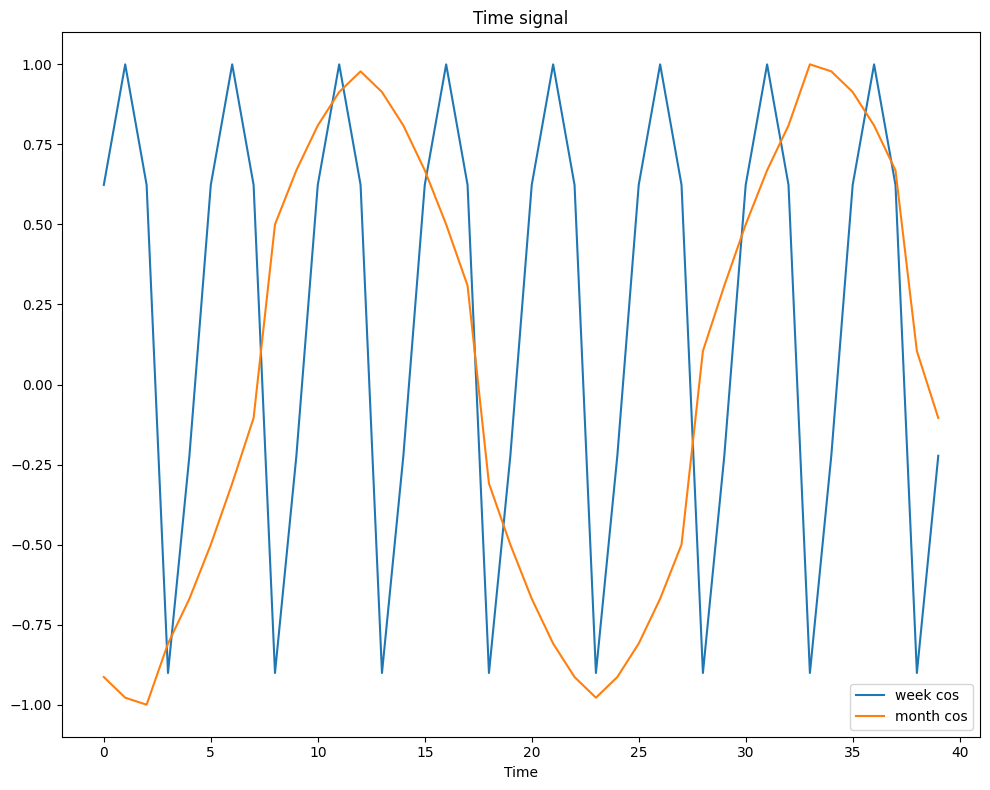

In [14]:
plt.figure(figsize=(10, 8))

plt.plot(np.array(df['week cos'][:40]), label ='week cos')
plt.plot(np.array(df['month cos'][:40]), label = 'month cos')
plt.legend()
plt.xlabel('Time')
plt.title('Time signal')

plt.tight_layout()

Normalize data - Pipeline

In [15]:
df.reset_index(drop=True, inplace=True)

In [16]:
df.columns

Index(['KLGD', 'GTGD', 'capital', 'close_price', 'daily_return',
       'daily_return_pct', 'KL', 'GT', 'MA10', 'MA20', 'week sin', 'week cos',
       'month sin', 'month cos'],
      dtype='object')

In [17]:
df.head()

,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT,MA10,MA20,week sin,week cos,month sin,month cos
0,1562400,219300,103215,141000,900.0,0.64,1167000,161990,145320.0,150510.0,-7.818315e-01,0.623490,4.067366e-01,-0.913545
1,1833900,252506,98384,134400,-6600.0,-4.68,1705600,233158,143880.0,149595.0,2.119260e-13,1.000000,2.079117e-01,-0.978148
2,3596500,481570,91576,125100,-9300.0,-6.92,2746800,359383,141670.0,148040.0,7.818315e-01,0.623490,-1.083508e-14,-1.000000
3,1364200,172666,90039,123000,-2100.0,-1.68,1334500,168692,139470.0,146215.0,-4.338837e-01,-0.900969,-5.877853e-01,-0.809017
4,1055800,134181,96334,131600,8600.0,6.99,1055800,134181,137710.0,144785.0,-9.749279e-01,-0.222521,-7.431448e-01,-0.669131


In [18]:
def divide_1000 (x):
    return x/1000

In [19]:
num_cols = ['KLGD', 'GTGD', 'capital', 'close_price','daily_return', 'KL', 'GT', 'MA10', 'MA20'] 
other_cols = ['daily_return_pct','week sin', 'week cos','month sin', 'month cos']

In [20]:
Numerical = Pipeline(steps=[('impute_zero', SimpleImputer(missing_values=np.nan, fill_value=0)), ('divide_1000', FunctionTransformer(divide_1000)), 
                             ('standard scaler',StandardScaler())])

transformer = ColumnTransformer(transformers=[('Numerical',Numerical, num_cols)])

In [21]:
# Numerical.fit(df[num_cols])

In [22]:
df_temp = df.copy()

In [23]:
Numerical.fit(df[num_cols])
df_trans = Numerical.transform(df[num_cols])

In [24]:
df_trans = pd.DataFrame(df_trans, columns=num_cols)
df_trans.reset_index(drop=True, inplace=True)
df_trans.head()

,KLGD,GTGD,capital,close_price,daily_return,KL,GT,MA10,MA20
0,-0.909892,0.012480,1.267814,2.570719,0.495902,-1.049337,-0.097302,2.550583,2.528580
1,-0.791325,0.257485,1.009118,2.352891,-3.174912,-0.713941,0.556987,2.504768,2.500678
2,-0.021574,1.947592,0.644555,2.045951,-4.496404,-0.065569,1.717448,2.434455,2.453258
3,-0.996449,-0.331600,0.562250,1.976642,-0.972424,-0.945031,-0.035686,2.364461,2.397605
4,-1.131131,-0.615555,0.899342,2.260479,4.264604,-1.118583,-0.352966,2.308465,2.353998


In [25]:
for col in other_cols:
    df_trans[col] = df[col]

In [26]:
df_trans.head()

,KLGD,GTGD,capital,close_price,daily_return,KL,GT,MA10,MA20,daily_return_pct,week sin,week cos,month sin,month cos
0,-0.909892,0.012480,1.267814,2.570719,0.495902,-1.049337,-0.097302,2.550583,2.528580,0.64,-7.818315e-01,0.623490,4.067366e-01,-0.913545
1,-0.791325,0.257485,1.009118,2.352891,-3.174912,-0.713941,0.556987,2.504768,2.500678,-4.68,2.119260e-13,1.000000,2.079117e-01,-0.978148
2,-0.021574,1.947592,0.644555,2.045951,-4.496404,-0.065569,1.717448,2.434455,2.453258,-6.92,7.818315e-01,0.623490,-1.083508e-14,-1.000000
3,-0.996449,-0.331600,0.562250,1.976642,-0.972424,-0.945031,-0.035686,2.364461,2.397605,-1.68,-4.338837e-01,-0.900969,-5.877853e-01,-0.809017
4,-1.131131,-0.615555,0.899342,2.260479,4.264604,-1.118583,-0.352966,2.308465,2.353998,6.99,-9.749279e-01,-0.222521,-7.431448e-01,-0.669131


Split data

In [27]:
# Get the number of rows to train the model on
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df_trans)
train_df = df_trans[0:int(n*0.7)]
val_df = df_trans[int(n*0.7):int(n*0.9)]
test_df = df_trans[int(n*0.9):]

num_features = df_trans.shape[1]
print ('len(train_df)',len(train_df))

len(train_df) 161


# TRAINING

Make sliding window

In [28]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [29]:
OUT_STEPS = 5
input_width =15 
multi_window = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,label_columns = ['close_price'])
multi_window

Total window size: 20
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label indices: [15 16 17 18 19]
Label column name(s): ['close_price']

Split Window

In [30]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [31]:
# Example for split window
example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[50:50+multi_window.total_window_size]),
                           np.array(train_df[100:100+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 20, 14)
Inputs shape: (3, 15, 14)
Labels shape: (3, 5, 1)


Plot

In [32]:
def plot(self, model=None, plot_col='close_price', max_subplots=3):
    
    inputs, labels = self.split_window(example_window)
    plt.figure(figsize=(20, 10))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [day]')

WindowGenerator.plot = plot

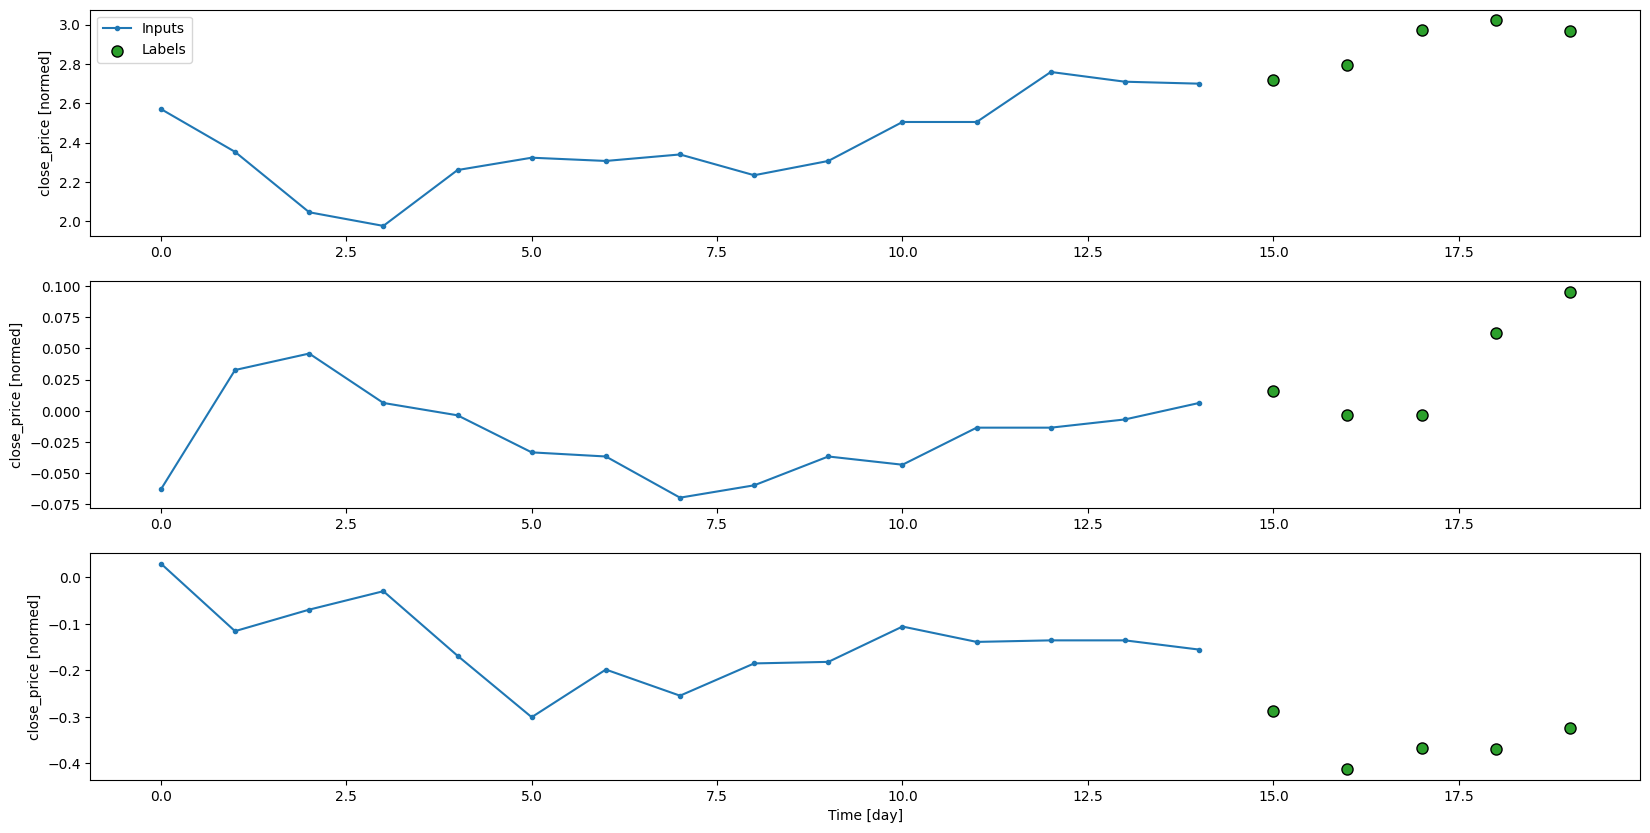

In [33]:
multi_window.plot()

Create dataset

In [34]:
def make_dataset(self, data): #data lấy liên tục 
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,#to avoid sequence bias
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [35]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [36]:
for inputs, labels in multi_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

Inputs shape (batch, time, features): (32, 15, 14)
Labels shape (batch, time, features): (32, 5, 1)


In [37]:
multi_window.train

<_MapDataset element_spec=(TensorSpec(shape=(None, 15, 14), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None))>

Build and Train model

In [38]:
tf.keras.backend.clear_session()
MAX_EPOCHS = 100

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def compile_and_fit(model, window, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

        
    model.compile(#loss=tf.keras.losses.MeanSquaredError()
                  loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping,lr_schedule],verbose=1)
    return history

In [39]:
def plot_train (history):
    # list all data in history
    print(history.history.keys())

    # summarize history for loss

    fig, ax = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

Simple CNN

In [40]:
CONV_WIDTH =3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

1/1 [==============================] - 0s 30ms/step - loss: 0.0202 - mean_absolute_error: 0.1693 - root_mean_squared_error: 0.2012
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


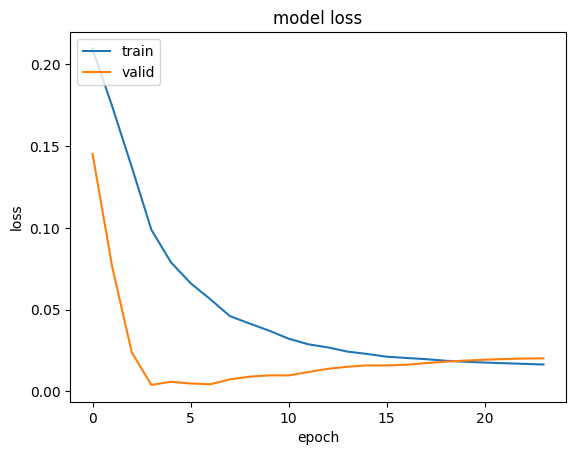

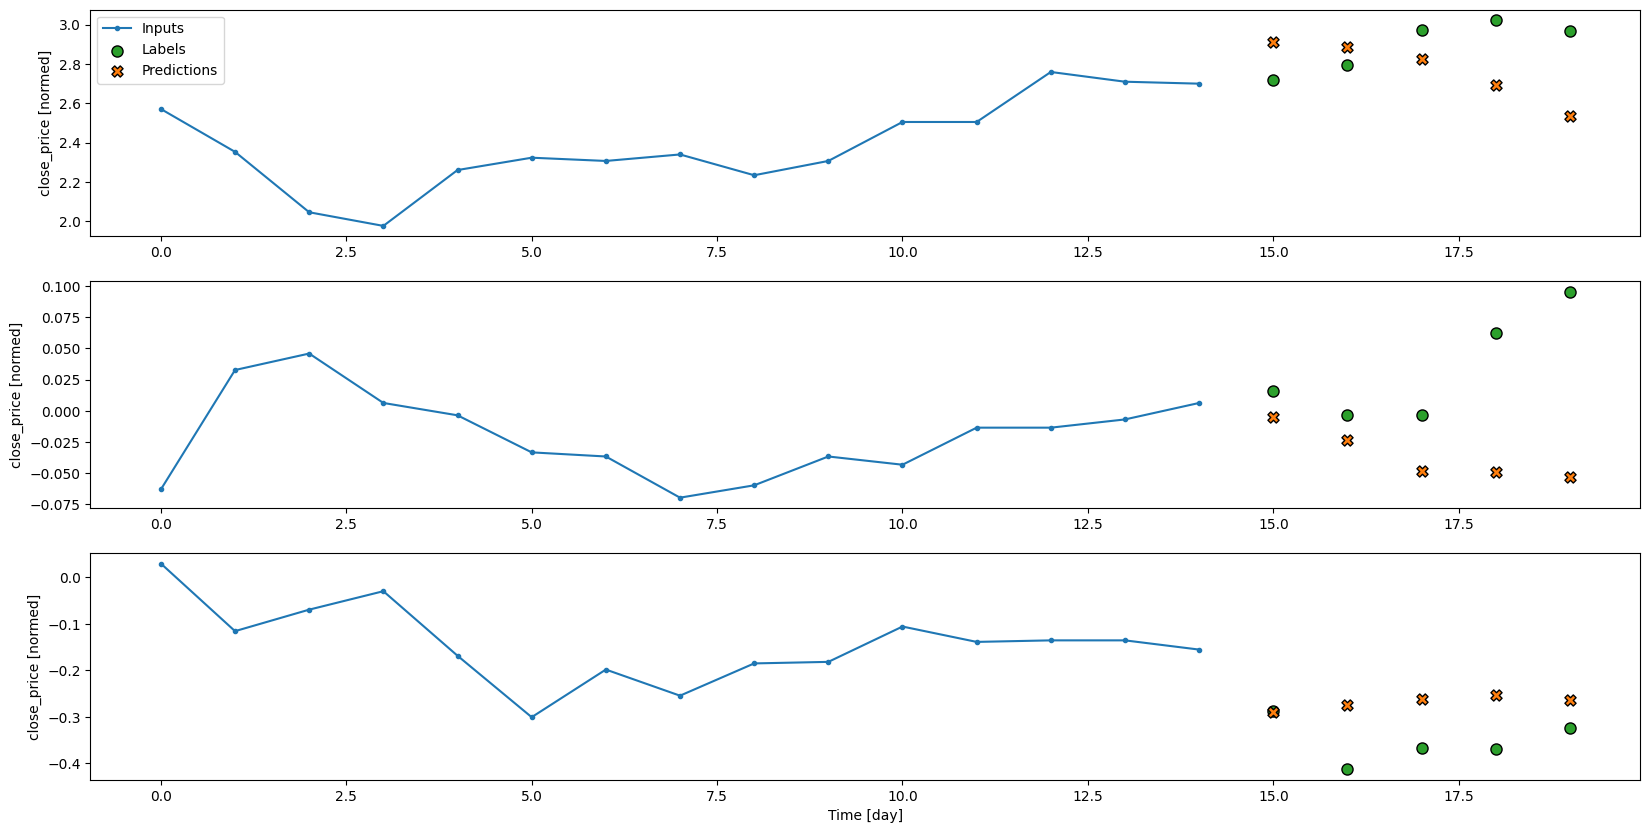

In [41]:
multi_conv_history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance = {}
multi_performance = {}

IPython.display.clear_output()

multi_val_performance['Simple Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Simple Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
plot_train(multi_conv_history)
multi_window.plot(multi_conv_model)

In [42]:
multi_conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 3, 14)             0         
                                                                 
 conv1d (Conv1D)             (None, 1, 256)            11008     
                                                                 
 dense (Dense)               (None, 1, 70)             17990     
                                                                 
 reshape (Reshape)           (None, 5, 14)             0         
                                                                 
Total params: 28,998
Trainable params: 28,998
Non-trainable params: 0
_________________________________________________________________


Multi LSTM

1/1 [==============================] - 0s 128ms/step - loss: 0.0082 - mean_absolute_error: 0.1011 - root_mean_squared_error: 0.1277
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


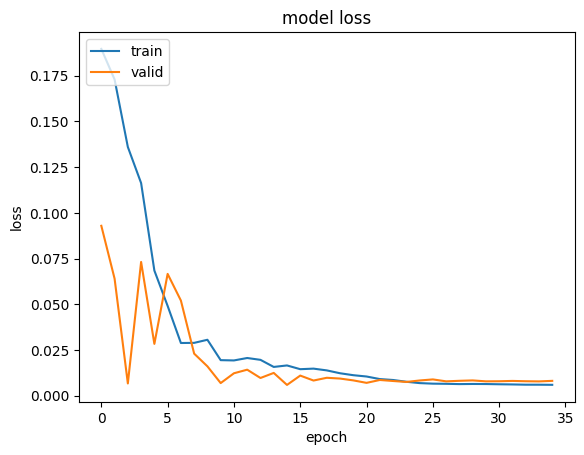

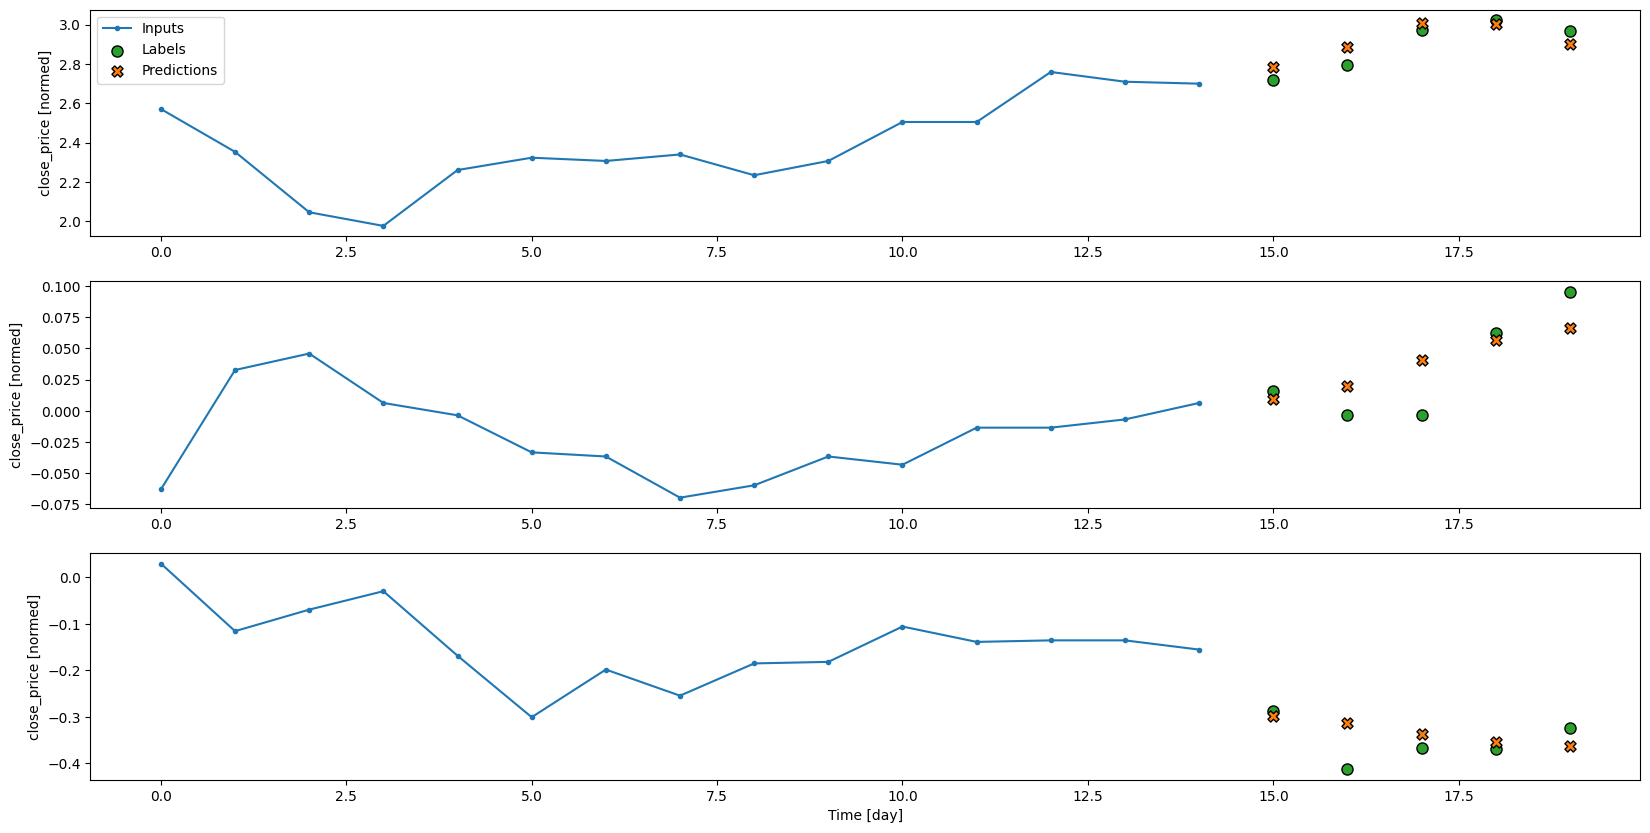

In [43]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(1024, return_sequences=True),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.LSTM(1024, return_sequences=False),
    
    tf.keras.layers.Dense(512, activation = 'relu'), 
    
    tf.keras.layers.Dense(256),
    
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history_multi_lstm = compile_and_fit(multi_lstm_model, multi_window)
IPython.display.clear_output()
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
plot_train(history_multi_lstm)
multi_window.plot(multi_lstm_model)

In [44]:
multi_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 1024)          4255744   
                                                                 
 lstm_1 (LSTM)               (None, 1024)              8392704   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 70)                17990     
                                                                 
 reshape_1 (Reshape)         (None, 5, 14)             0         
                                                                 
Total params: 13,322,566
Trainable params: 13,322,566


Complex CNN

In [45]:
CONV_WIDTH = 3

def build_CNN_model(input_shape = (input_width,num_features)): #input_shape (time steps,features)
    
    input = tf.keras.Input(shape=(input_shape[0],input_shape[1],1))
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)))(input)

    #x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    
    #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)))(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    
    x = tf.keras.layers.Dropout(0.5)(x) 
    
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(512)(x)
                              
    x = tf.keras.layers.Dense(OUT_STEPS*num_features) (x)
    # Shape => [batch, out_steps, features]
    output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

CNN_model = build_CNN_model()
CNN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 14, 1)]       0         
                                                                 
 time_distributed (TimeDistr  (None, 15, 12, 64)       256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 10, 128)      24704     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 8, 256)       98560     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 6, 128)       98432     
 tributed)                                                   

1/1 [==============================] - 0s 50ms/step - loss: 0.0145 - mean_absolute_error: 0.1515 - root_mean_squared_error: 0.1704
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


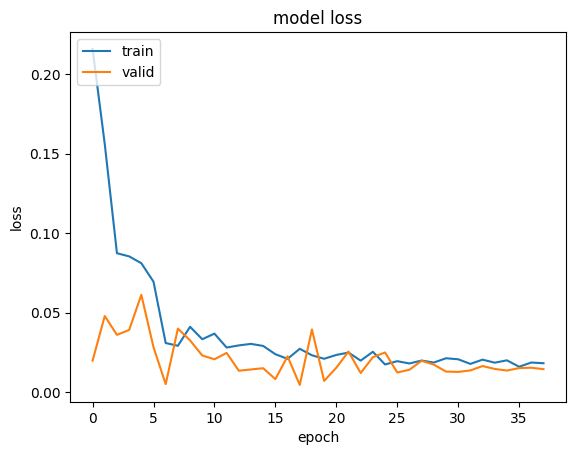

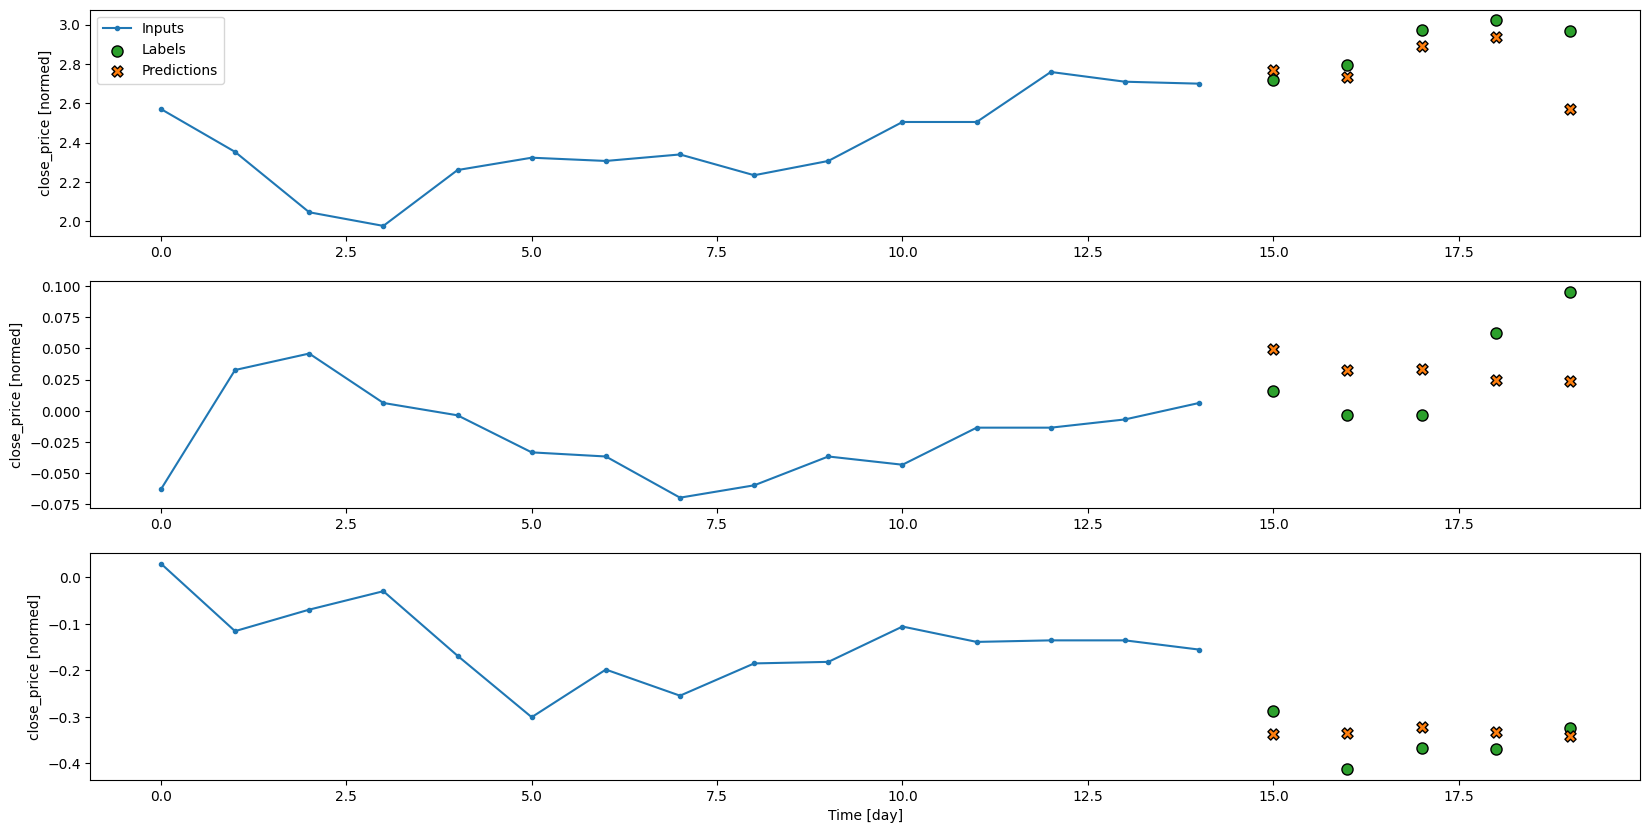

In [46]:
tf.keras.backend.clear_session()
history_CNN = compile_and_fit(CNN_model, multi_window)

#multi_val_performance = {}
#multi_performance = {}
IPython.display.clear_output()
multi_val_performance['CNN'] = CNN_model.evaluate(multi_window.val)
multi_performance['CNN'] = CNN_model.evaluate(multi_window.test, verbose=0)
plot_train(history_CNN)
multi_window.plot(CNN_model)

CNN + LSTM

In [80]:
CONV_WIDTH = 3

def build_CNN_LSTM_model(input_shape = (input_width,num_features)):
    
    input = tf.keras.Input(shape=(input_shape[0],input_shape[1],1))
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)))(input)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)))(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    
    # x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
    
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True))(x)
    
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=False, dropout=0.5))(x)
    
    x = tf.keras.layers.Dense(OUT_STEPS*num_features)(x)

    output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

CNN_LSTM_model = build_CNN_LSTM_model()
CNN_LSTM_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15, 14, 1)]       0         
                                                                 
 time_distributed_8 (TimeDis  (None, 15, 12, 64)       256       
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 15, 6, 64)        0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 4, 128)       24704     
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 2, 128)       0         
 stributed)                                                

1/1 [==============================] - 0s 37ms/step - loss: 0.0210 - mean_absolute_error: 0.1808 - root_mean_squared_error: 0.2051
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


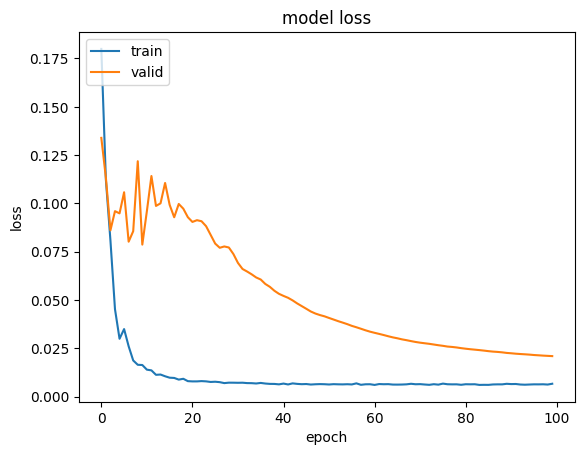

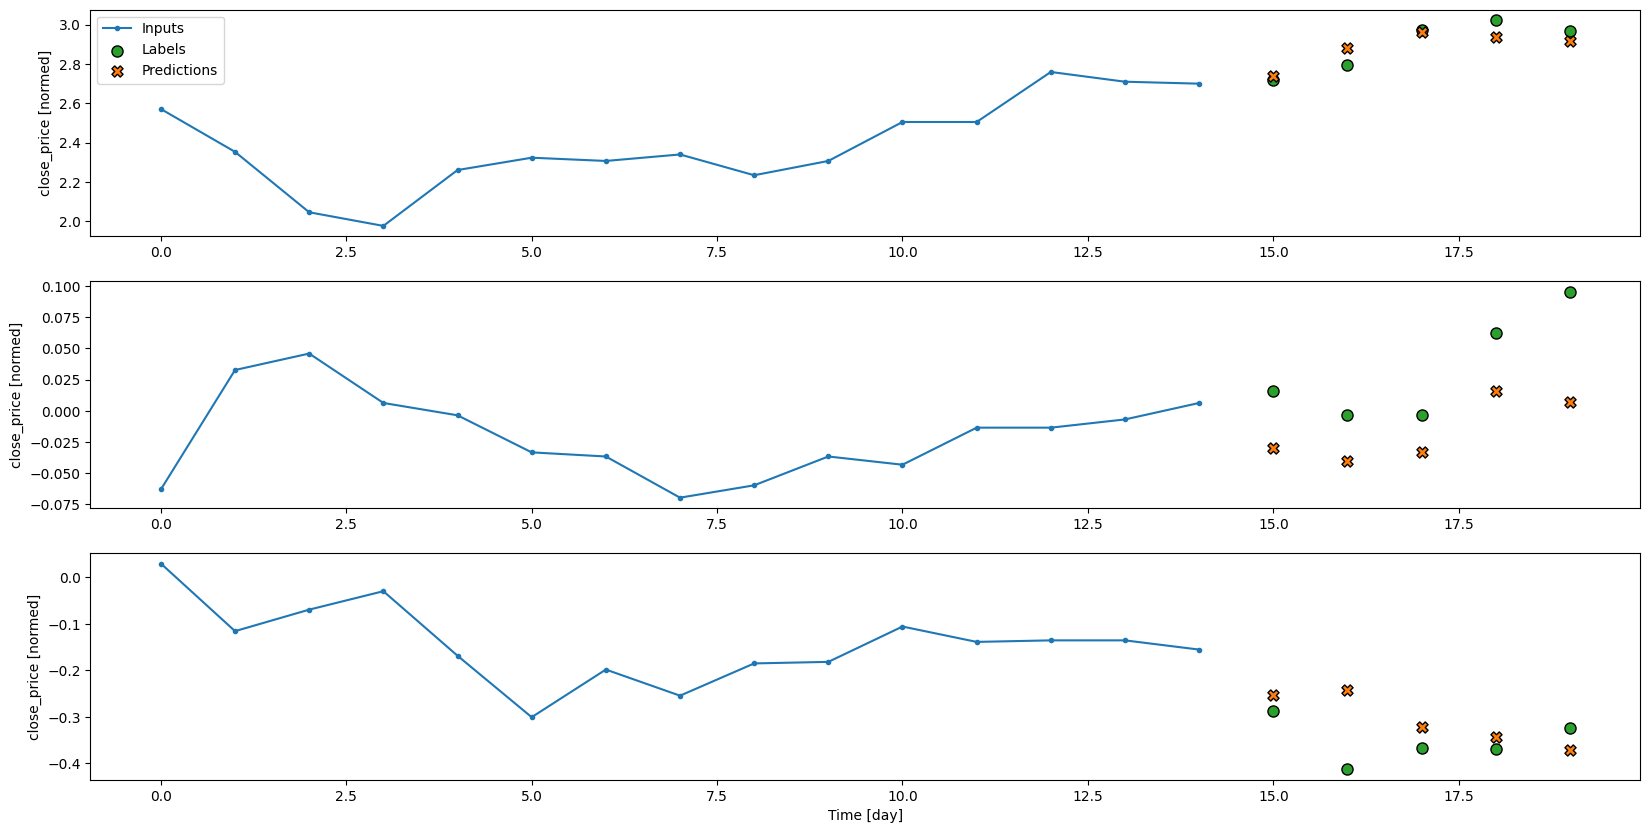

In [81]:
history_CNN_LSTM = compile_and_fit(CNN_LSTM_model, multi_window)

#multi_val_performance = {}
#multi_performance = {}
IPython.display.clear_output()
multi_val_performance['CNN_LSTM'] = CNN_LSTM_model.evaluate(multi_window.val)
multi_performance['CNN_LSTM'] = CNN_LSTM_model.evaluate(multi_window.test, verbose=0)
plot_train(history_CNN_LSTM)
multi_window.plot(CNN_LSTM_model)

LSTM + Dense

In [82]:
def build_LSTM_Dense_model():
    
    input = tf.keras.Input(shape= (input_width,num_features))
    
    x = tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True))(input)
    
    x = tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True, dropout=0.5))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='relu'))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation='relu'))(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(OUT_STEPS*num_features)(x)

    output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

LSTM_Dense_model = build_LSTM_Dense_model()
LSTM_Dense_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15, 14)]          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 15, 512)          555008    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 15, 512)          1574912   
 nal)                                                            
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 256)          131328    
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 128)          32896     
 stributed)                                                

1/1 [==============================] - 0s 54ms/step - loss: 0.0846 - mean_absolute_error: 0.3390 - root_mean_squared_error: 0.4116
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


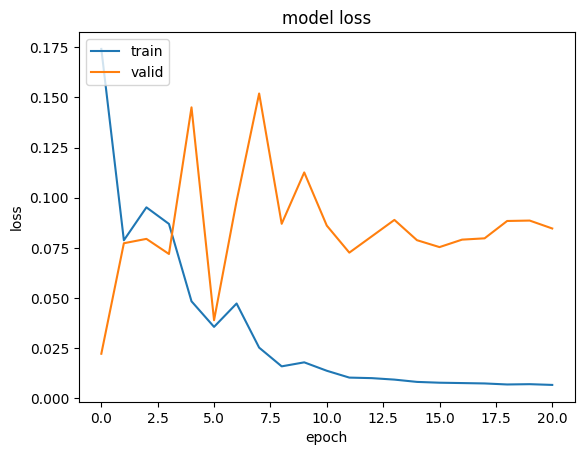

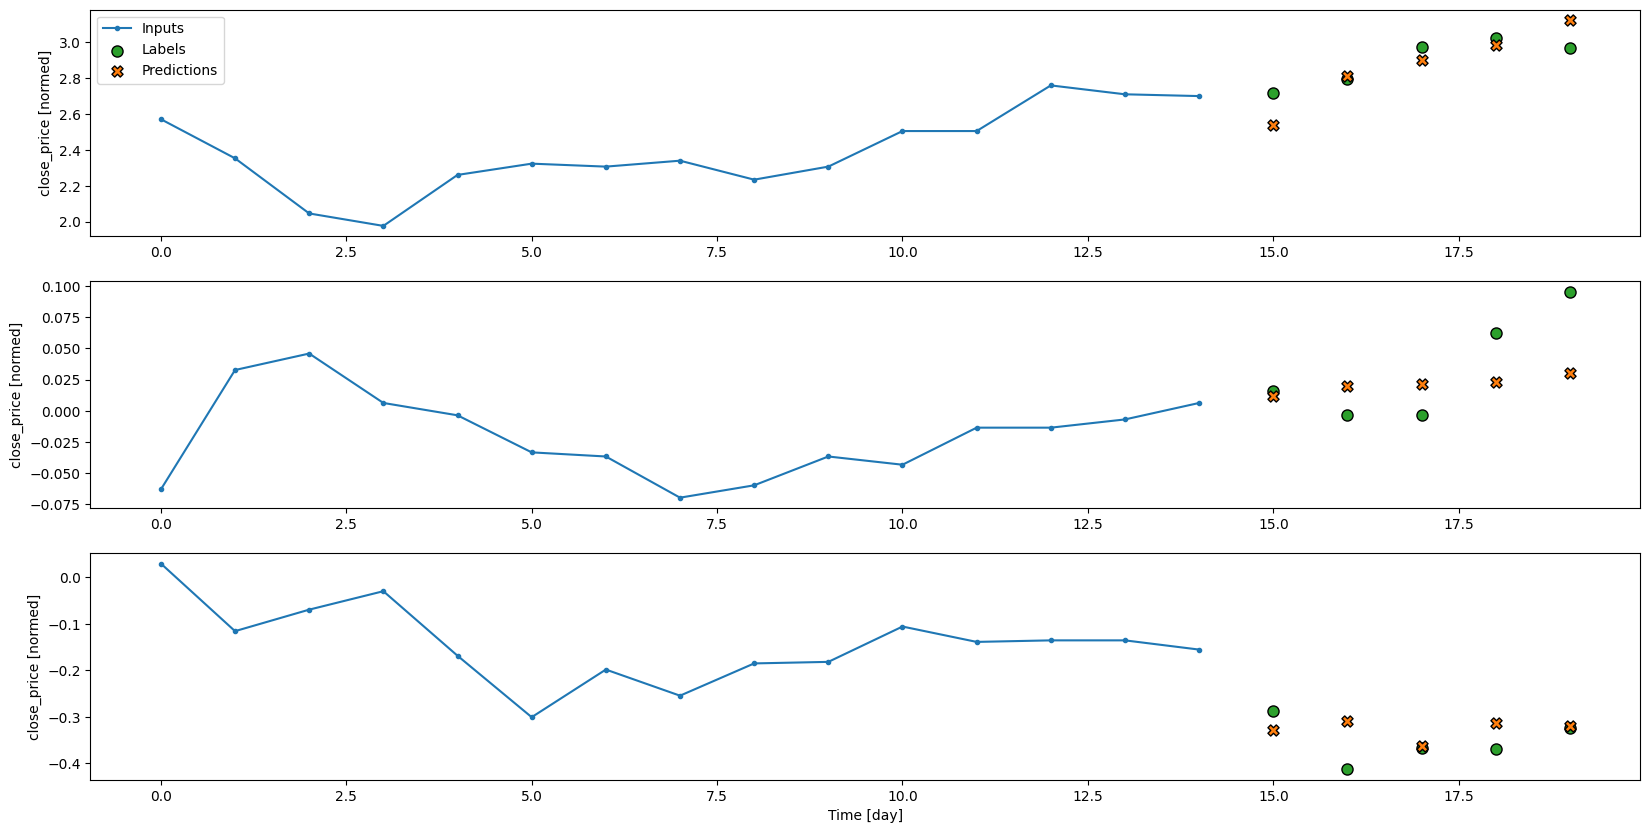

In [83]:
history_LSTM_Dense = compile_and_fit(LSTM_Dense_model, multi_window)

#multi_val_performance = {}
#multi_performance = {}
IPython.display.clear_output()
multi_val_performance['LSTM_Dense'] = LSTM_Dense_model.evaluate(multi_window.val)
multi_performance['LSTM_Dense'] = LSTM_Dense_model.evaluate(multi_window.test, verbose=0)
plot_train(history_LSTM_Dense)
multi_window.plot(LSTM_Dense_model)

# RESULT 

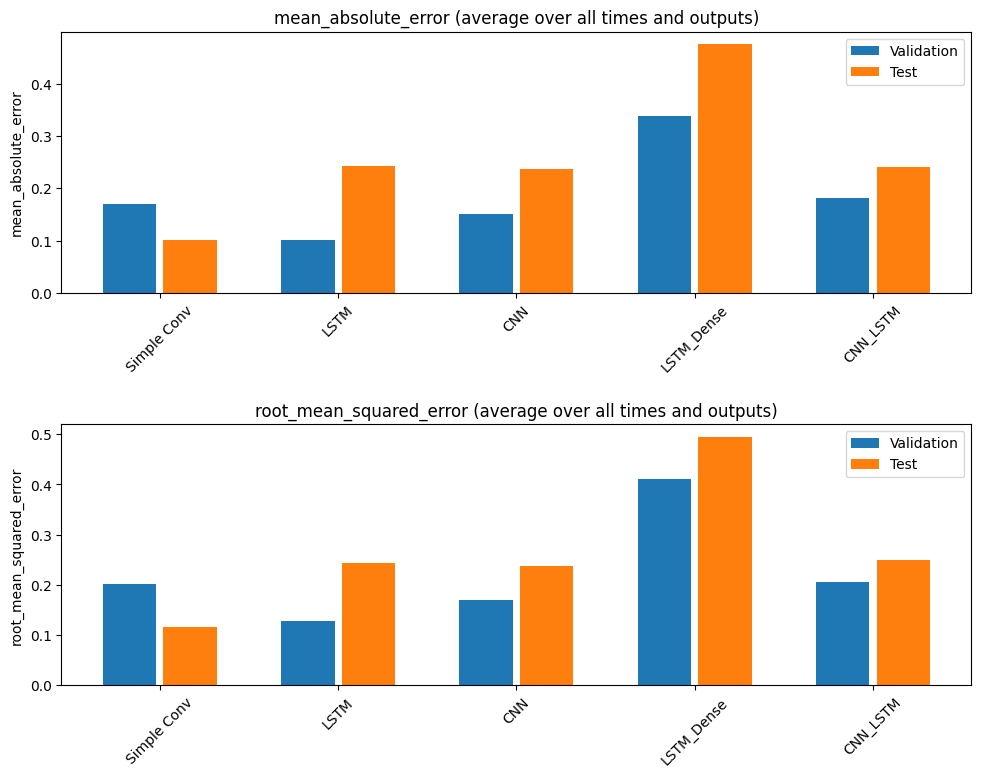

In [84]:
x = np.arange(len(multi_performance))
width = 0.3

plt.figure(figsize=(10, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)

metric_name = LSTM_Dense_model.metrics_names[1:] #we don't draw loss
for i, name in enumerate(metric_name,1):
    plt.subplot(2, 1, i)
    
    metric_index = LSTM_Dense_model.metrics_names.index(name)
    val_mae = [v[metric_index] for v in multi_val_performance.values()]
    test_mae = [v[metric_index] for v in multi_performance.values()]

    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.title (f'{name} (average over all times and outputs)')
    plt.xticks(ticks=x, labels=multi_performance.keys(),
               rotation=45)
    plt.ylabel(f'{name}') #(average over all times and outputs)
    _ = plt.legend()
    
plt.tight_layout()

# INFERENCE

In [85]:
test_window = tf.stack([np.array(test_df[test_df.shape[0] - input_width: test_df.shape[0]])])


In [86]:
scaler = Numerical.named_steps['standard scaler']

Denormalize prediction

In [87]:
def denorm(inputs,scaler, num_cols = num_cols):
    denorm_array = []
    for input in inputs:
        denorm_input = scaler.inverse_transform(input[:,:len(num_cols)])
        denorm_array.append(denorm_input)
    denorm_array = np.array(denorm_array,dtype=float)    
    return denorm_array

In [127]:
def plot_inference_denorm(self, model=None, plot_col='close_price', max_subplots=1, inputs = test_window, model_name = "model"):
    
    
    denorm_inputs = denorm(inputs, scaler)
    # print (denorm_input[:, plot_col_index])
    plt.figure(figsize=(20, 7))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [denormed]')
        plt.plot(self.input_indices, denorm_inputs[n,:, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if model is not None:
            predictions = model(inputs)
            denormalized_predictions = denorm(predictions,scaler)

            plt.scatter(self.label_indices, denormalized_predictions[n, :, plot_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
            print (denormalized_predictions[n, :, plot_col_index])
            plt.title(model_name)
        if n == 0:
            plt.legend(loc='upper left')

    plt.xlabel('Time [day]')
    

WindowGenerator.plot_inference_denorm = plot_inference_denorm

All models

In [128]:
models = [multi_conv_model, multi_lstm_model, CNN_model,LSTM_Dense_model,CNN_LSTM_model]

dict_keys(['Simple Conv', 'LSTM', 'CNN', 'LSTM_Dense', 'CNN_LSTM'])
Simple Conv
[47.95921954 47.70105113 46.9819548  46.87175288 46.40314779]
LSTM
[46.34053491 46.31937259 46.16591235 46.43695368 46.72520227]
CNN
[48.73512076 48.22703722 48.36305814 48.25337183 48.06881465]
LSTM_Dense
[43.30628277 42.38683426 44.40462495 42.88784563 46.0496171 ]
CNN_LSTM
[50.23092739 49.20260706 50.24124127 46.95726723 50.40521133]


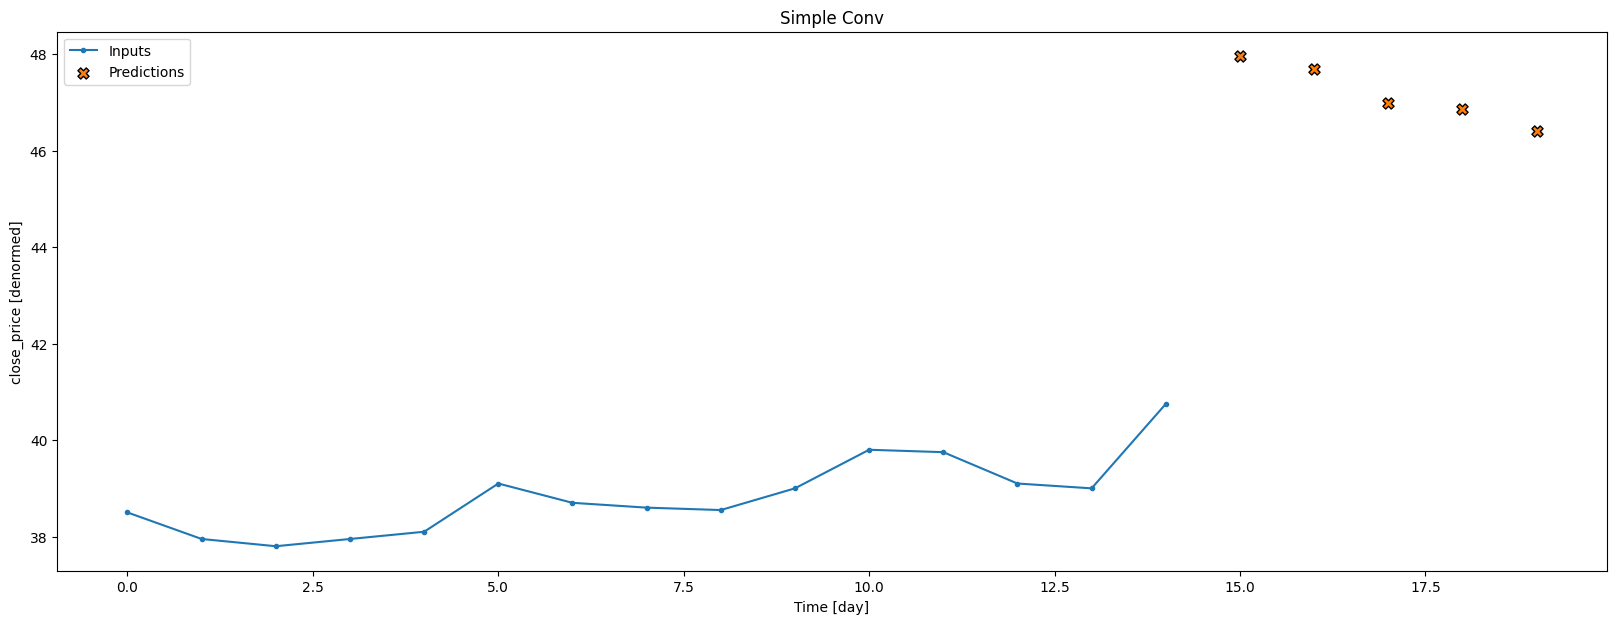

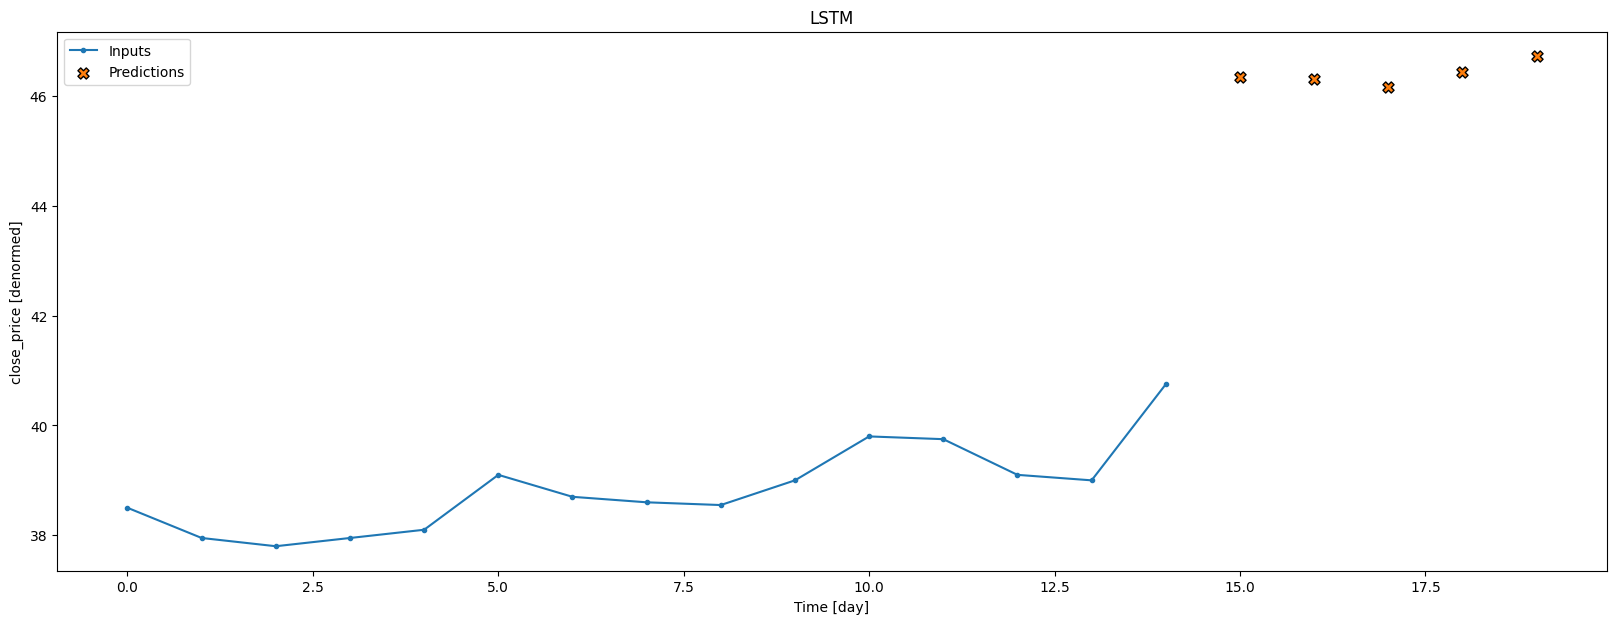

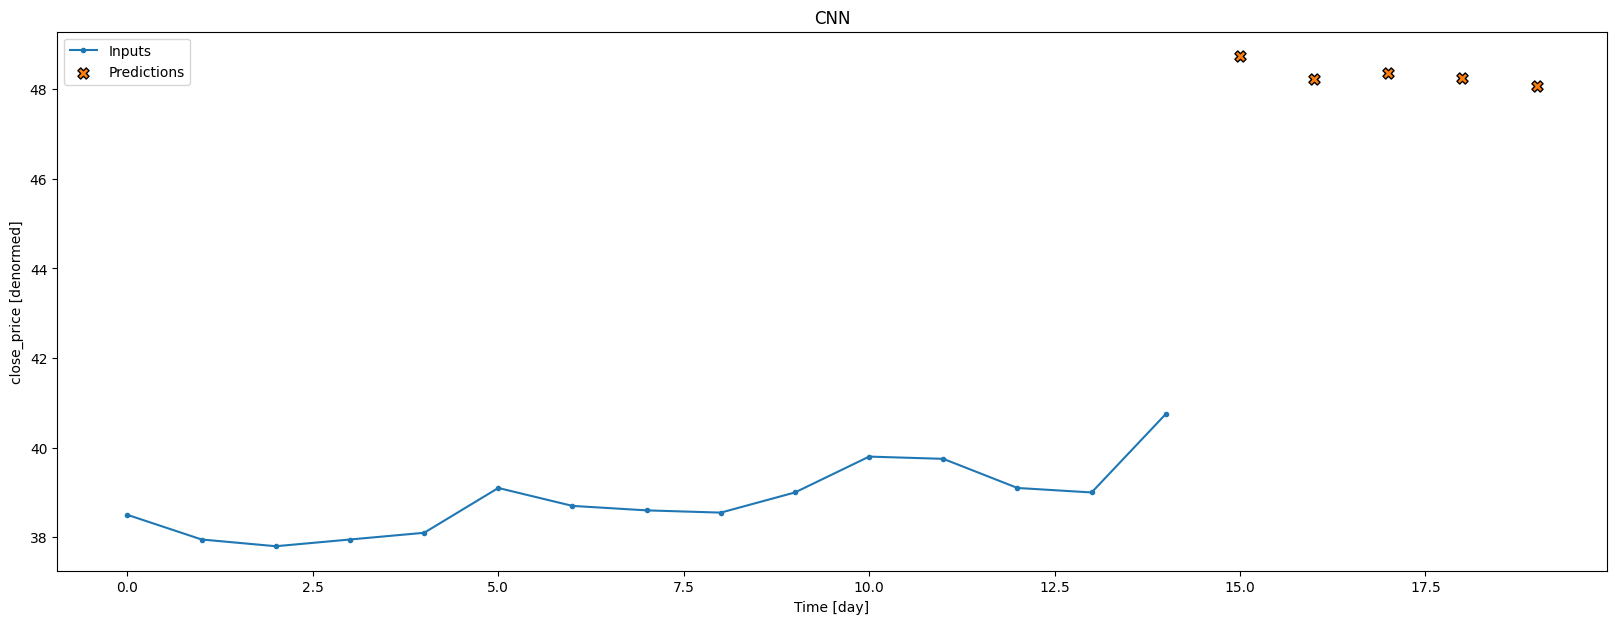

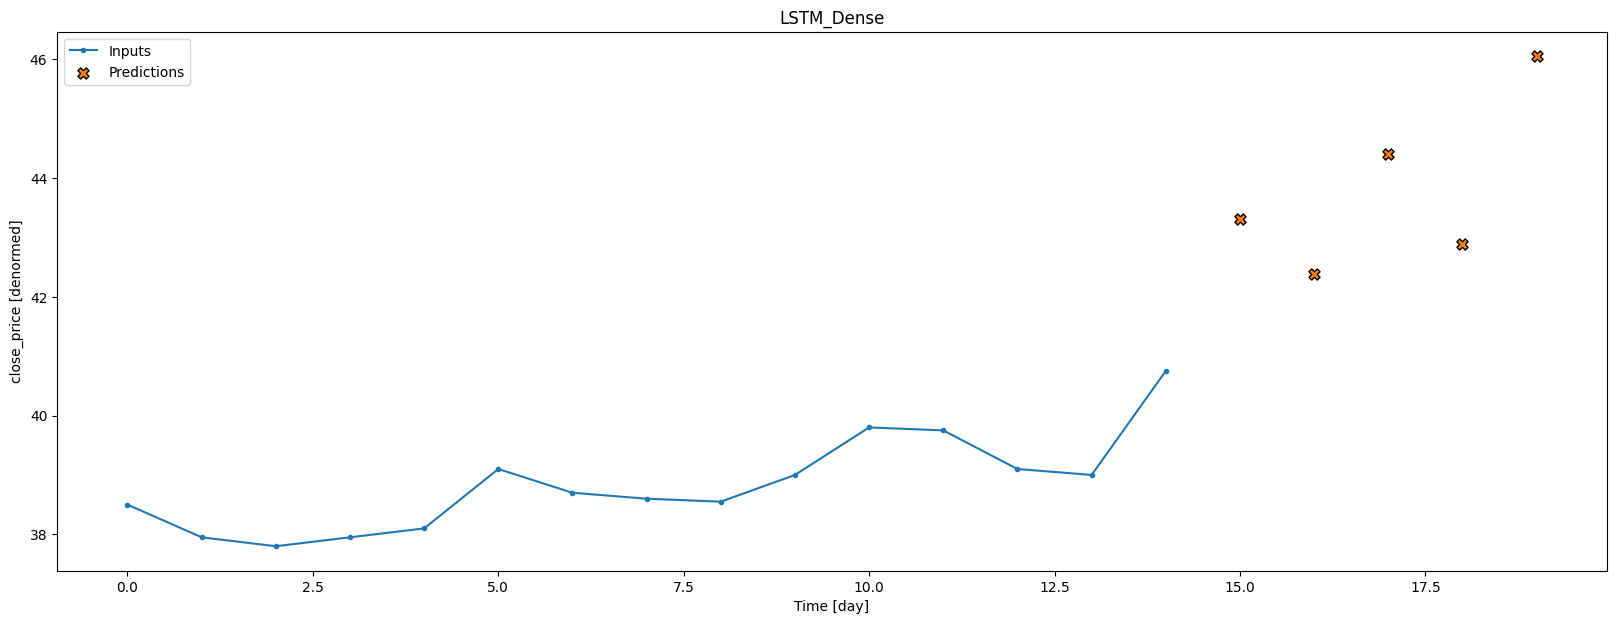

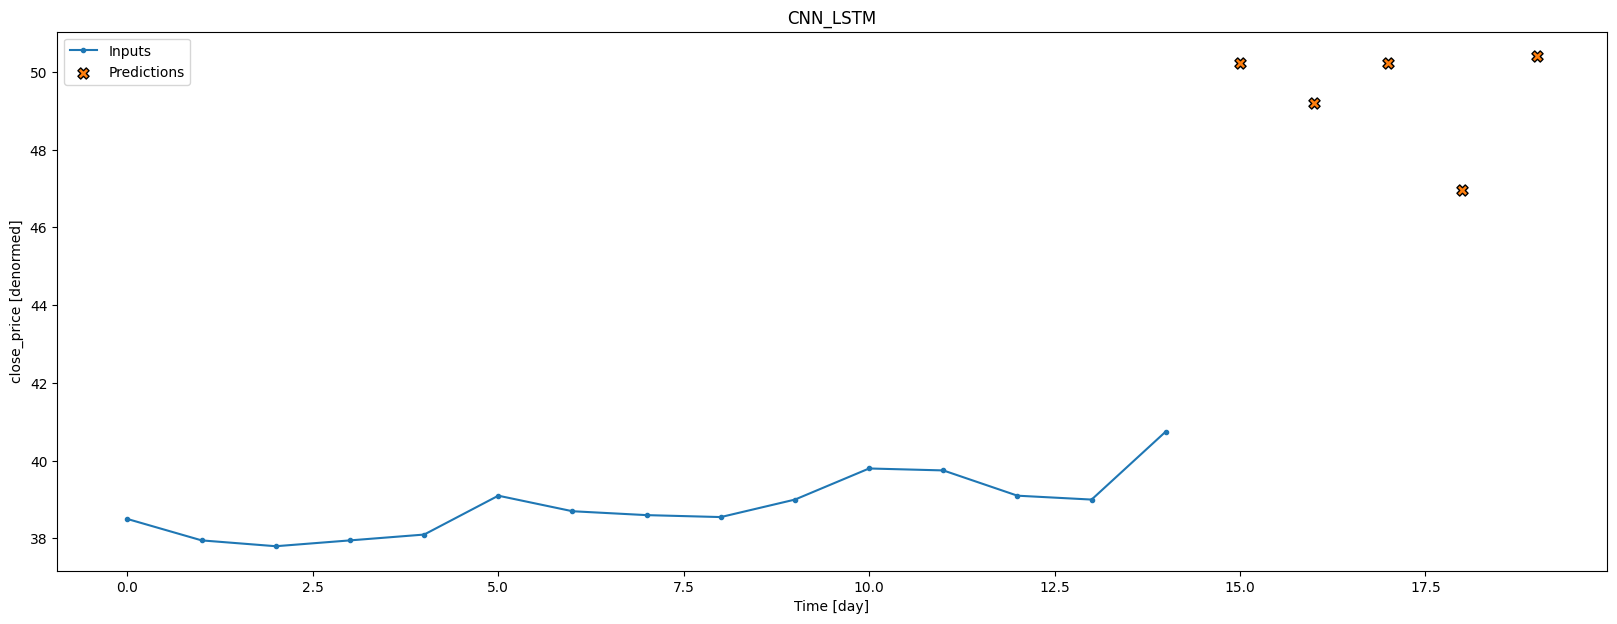

In [130]:
print(multi_performance.keys())
for model_name, model in zip(multi_performance.keys(), models):
    print (model_name)
    multi_window.plot_inference_denorm(model, model_name = model_name)